In [1]:
#Odwrócić kolejność predykcji w LSTM
#Użyć jako wejścia dla każdego elementu dekodera ukrytego stanu

In [2]:
import numpy as np
import torch
import torch.nn as nn
import pickle
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesResampler

/pio/scratch/1/i309016/miniconda/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
with open("../Dane/Datasets/d10-avg15.pickle", "rb") as file:
    dataset=pickle.load(file)

resampler=TimeSeriesResampler(256)

dataset=torch.Tensor([resampler.transform(ar.reshape((1,-1,1))).reshape(-1,1) for ar in dataset]).transpose(0,1)

In [4]:
class Siec(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.lstmEncoder=nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1)
        self.conv=nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(11,21), padding=(5,10), dilation=1)
        #poolingKernel=21
        #self.maxPool=nn.MaxPool1d(kernel_size=poolingKernel,return_indices=True)
        #self.unPool=nn.MaxUnpool1d(kernel_size=poolingKernel)
        self.lstmDecoder=nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1)
        #self.conv2=nn.Conv1d(in_channels=hidden_size, out_channels=1, kernel_size=21, padding=10, dilation=1)
        self.linear=nn.Linear(in_features=hidden_size, out_features=1)
        
        for n,p in self.lstmEncoder.named_parameters():
            if "weight_hh" in n:
                nn.init.orthogonal_(p)
        for n,p in self.lstmDecoder.named_parameters():
            if "weight_hh" in n:
                nn.init.orthogonal_(p)
        
    def forward(self, X):
        X,_=self.lstmEncoder(X)
        #print(X.shape)
        X=X.permute(1,2,0)
        X=X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
        #print(X.shape)
        X=self.conv(X)
        #print(X.shape)
        X=X.reshape(X.shape[0], X.shape[2], X.shape[3])
        #print(X.shape)

        #X=self.unPool(*self.maxPool(self.conv(X)), output_size=X.size())
        
        X=X.permute(2,0,1)
        #print(X.shape)
        X,_=self.lstmDecoder(X)
        X=self.linear(X)
        return X

In [5]:
def uczModel(model, dataset, validationset, batch_size=128, ifCuda=True, lr=1e-3, epoch_count=30,
            log_every=50, przesuniecie=11):
    def evalBatch(batch):
        if ifCuda:
            batch=batch.to("cuda")
        result=model(batch)
        diffrenceWithNext=(result[:-przesuniecie,:,:]-batch[przesuniecie:,:,:])**2
        score=torch.sum(diffrenceWithNext)
        return score
    
    if ifCuda:
        model=model.to("cuda")
    
    bestAvgValidationScore=np.inf
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    iter_counter=0
    
    try:    
        for epoch in range(epoch_count):
            #Training
            for batch_ind in range(0,dataset.shape[1],batch_size):
                batch=dataset[:,batch_ind:batch_ind+batch_size,:]
                iter_counter+=1
                optimizer.zero_grad()
                score=evalBatch(batch)
                score.backward()
                optimizer.step()
                if iter_counter % log_every == 0:
                    print("Minibatch {0: >6}  | avg. loss {1: >9.7f}".format(
                        iter_counter,score.item()/batch_size))
            #Validation
            validationScore=0
            with torch.no_grad():
                for batch_ind in range(0,validationset.shape[1],batch_size):
                    batch=validationset[:,batch_ind:batch_ind+batch_size,:]
                    validationScore+=evalBatch(batch)
            avgValidationScore=validationScore/validationset.shape[1]

            if avgValidationScore < bestAvgValidationScore:
                best_epoch = epoch
                bestAvgValidationScore=avgValidationScore
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid score: {1: >9.7f} | best valid score: {2: >9.7f} | best epoch {3: >3}".format(
                epoch, avgValidationScore, bestAvgValidationScore, best_epoch
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param       

In [6]:
model=Siec(32)

In [7]:
dataset.shape

torch.Size([256, 45330, 1])

In [8]:
podzial=42000
W=uczModel(model, dataset[:,:podzial,:],dataset[:,-podzial:,:], batch_size=128, 
           log_every=20, lr=0.001, epoch_count=30,przesuniecie=12)

--------------------------------------------------------------------------------------
After epoch 29 | valid score: 0.0033534 | best valid score: 0.0033534 | best epoch  29
--------------------------------------------------------------------------------------

Loading best params on validation set (epoch 29)



In [9]:
szereg=dataset[:,0:2,:]
szereg=szereg.to("cuda")

In [10]:
X=model(szereg)

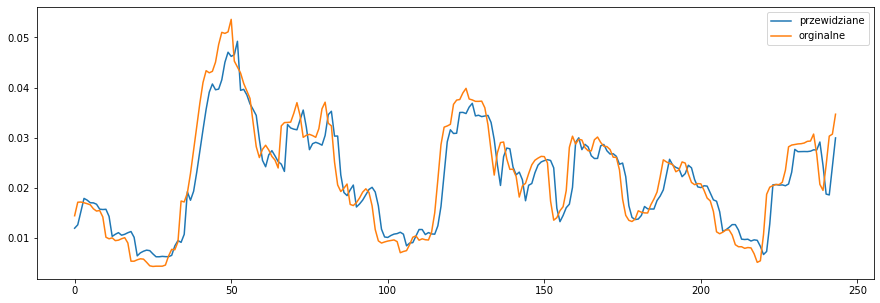

In [12]:
plt.gcf().set_size_inches((15,5))
#plt.xlim((200,300))
przes=12
plt.plot(np.array(X[:-przes,1,0].cpu().detach()), label="przewidziane")
plt.plot(np.array(szereg[przes:,1,0].cpu()), label="orginalne")
plt.legend()

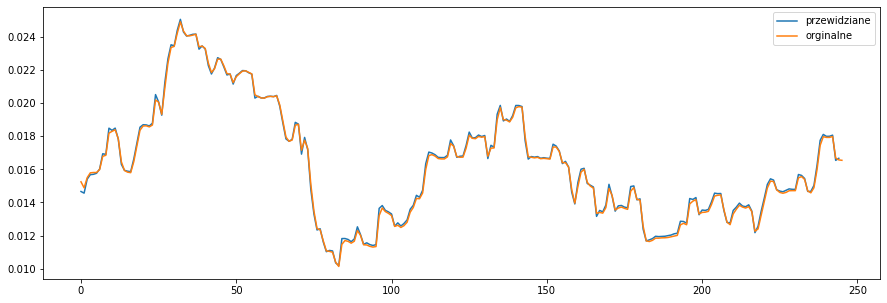

In [58]:
plt.gcf().set_size_inches((15,5))
#plt.xlim((200,300))
plt.plot(np.array(X[:-11,1,0].cpu().detach()), label="przewidziane")
plt.plot(np.array(szereg[10:,1,0].cpu()), label="orginalne")
plt.legend()

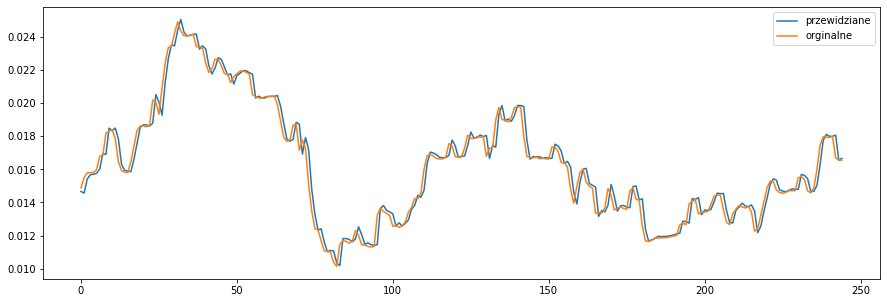

In [66]:
plt.gcf().set_size_inches((15,5))
#plt.xlim((200,300))
plt.plot(np.array(X[:-11,1,0].cpu().detach()), label="przewidziane")
plt.plot(np.array(szereg[11:,1,0].cpu()), label="orginalne")
plt.legend()

In [63]:
np.sum((np.array(X[:-11,0,0].cpu().detach())-np.array(szereg[11:,0,0].cpu()).ravel())**2)

0.00037370558

In [62]:
np.sum((np.array(X[:-11,1,0].cpu().detach())-np.array(szereg[10:-1,1,0].cpu()).ravel())**2)

4.5617985e-06

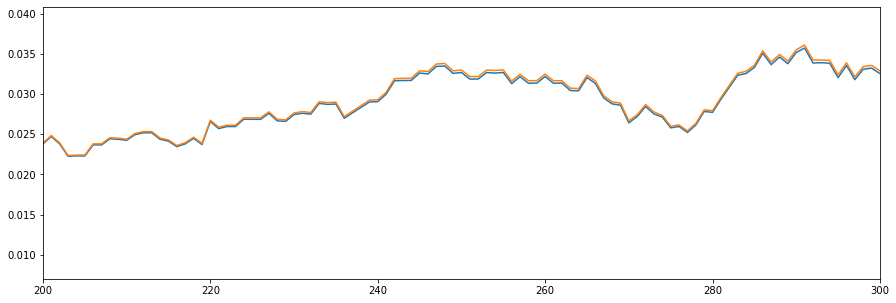

In [42]:
plt.gcf().set_size_inches((15,5))
plt.xlim((200,300))
plt.plot(np.array(X[:,0,0].cpu().detach()))
plt.plot(np.array(szereg[0]))

In [51]:
np.sum((np.array(X[:,0,0].cpu().detach())-np.array(szereg[0]).ravel())**2)

2.3230652e-05

In [52]:
np.sum((np.array(X[:-1,0,0].cpu().detach())-np.array(szereg[0][1:]).ravel())**2)

0.00052029593